The purpose of this notebook is to try to predict percentiles for spectra generated from SFHs not necessarily exponential, but with a model trained only with spectra from tau-delayed exponential SFHs. The idea is: even if the functional form of the SFH is different, the percentiles minimize that differences, so our model might be able to predict proper percentiles.

We load the modules we need

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference


import sys
from scipy import  integrate
from scipy import interpolate
import os
from astropy.io import fits

We define new parametrizations

0.1 0.0
1.0E+10


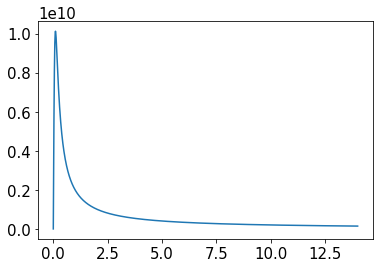

0.1 1.4444444444444444
1.0E+10


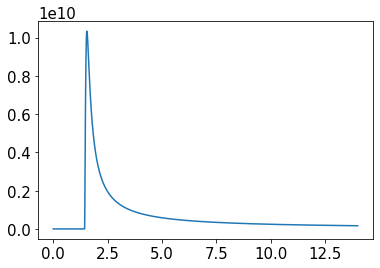

0.1 2.888888888888889
1.0E+10


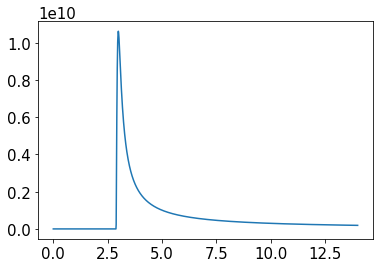

0.1 4.333333333333333
1.0E+10


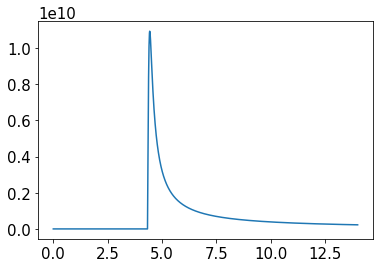

0.1 5.777777777777778
1.0E+10


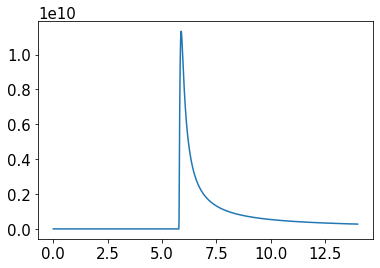

0.1 7.222222222222222
1.0E+10


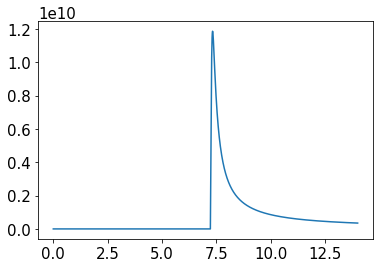

0.1 8.666666666666666
1.0E+10


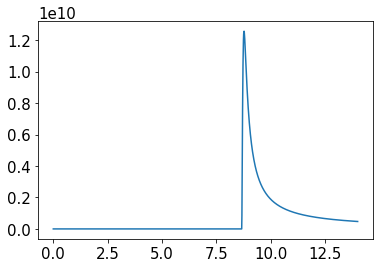

0.1 10.11111111111111
1.0E+10


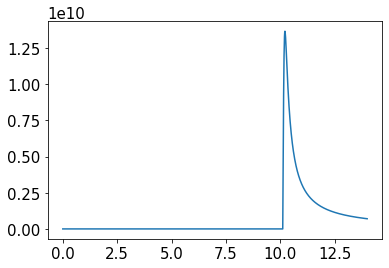

0.1 11.555555555555555
1.0E+10


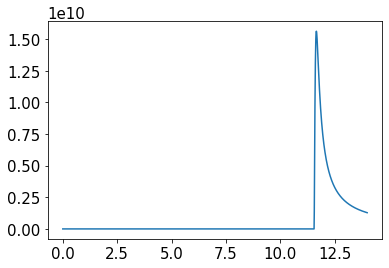

0.1 13.0
1.0E+10


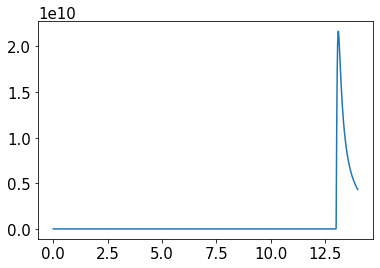

0.14949494949494951 0.0
1.0E+10


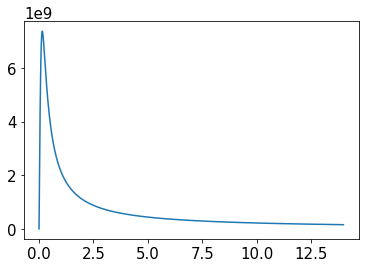

0.14949494949494951 1.4444444444444444
1.0E+10


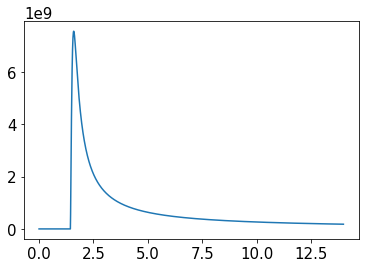

0.14949494949494951 2.888888888888889
1.0E+10


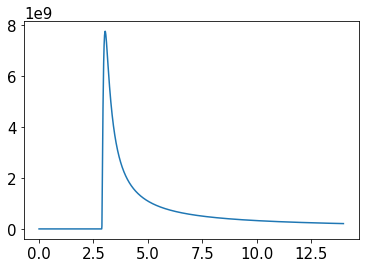

0.14949494949494951 4.333333333333333
1.0E+10


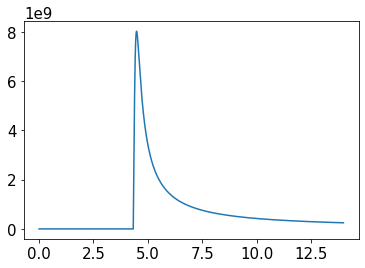

0.14949494949494951 5.777777777777778
1.0E+10


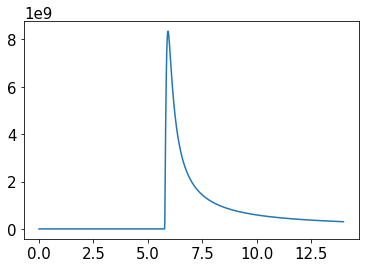

0.14949494949494951 7.222222222222222
1.0E+10


KeyboardInterrupt: 

In [34]:
def escalon(t,ti):
    return t>ti

def sfr_linear_lorentz(t,gamma,ti,mgal):
    i=integrate.quad(lambda t: (t-ti)/(np.pi*gamma * (1+((t-ti)/gamma)**2)) * escalon(t,ti),0,14)
    A=mgal/(i[0]+1e-12)
    return A*(t-ti)/(np.pi*gamma * (1+((t-ti)/gamma)**2)) * escalon(t,ti)



for i in np.linspace(0.1,5,100):
    for j in np.linspace(0,13,10):
        print(i,j)
        curve=sfr_linear_lorentz(np.arange(0,14,0.01),i,j,10**10) #unit Msun/Gyr
        print(format(np.sum(curve)*0.01,'.1E')) #unit Msun
        plt.plot(np.arange(0,14,0.01),curve)
        plt.show()

We generate the input training

In [35]:

def generate_weights_from_SFHs(SFR,mgal=10**10,gamma=np.linspace(0.1,5,10),ti=np.linspace(0,13,10),tmin=0,tmax=14,step=0.01,percen=True):
    curves=[]
    t=np.arange(tmin,tmax+step,step) 
    for i in gamma:
      for j in ti:
        curve=SFR(t,i,j,mgal)
        curves.append(curve)

    ms=[]
    #non accumulative mass curves, we save it cause we will use it later
    for index,curve in enumerate(curves):        
        sfr_0=curve
        m=[]
        for i,tx in enumerate(t):   
             m_t=sfr_0[i]*step #this gives directly the mass curve (non accumulative)
             m.append(m_t)
        ms.append(m/np.sum(m))

    if percen:
        #compute percentiles
        percentiles=[]
        for i,curve in enumerate(curves):
             mcurve=ms[i]
             m=[]
             percent=[]
             for j in range(len(mcurve)):
                m.append(np.sum(mcurve[:j+1]))
             for k in range(1,10):
                ind=np.argmin(abs(np.array(m)-k/10))
                percent.append(t[ind])
             percentiles.append(percent)  
        return t,ms,percentiles
    else:
        return t,ms

def get_tbins(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))     
    lib_n=np.array(sorted(lib_n))
    return lib_n

def get_data(dir_name,strs_1,strs_2):
    library=os.listdir(dir_name)
    x,y=len(strs_1),len(strs_2)
    lib=[]
    lib_n=[]
    for i,j in enumerate(library):
        if j[:x]==strs_1:
            lib.append(j[x:y+1])
            lib_n.append(float(j[x:y+1]))
        
    lib_n=np.array(lib_n)
    data=[]
    
    for j in range(len(lib_n)):
        globals() ['hdul'+str(j)]=fits.open(dir_name+'/'+strs_1+lib[j]+strs_2)
        data.append(np.array(globals()['hdul'+str(j)][0].data))

    hdr=hdul0[0].header
    wave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1'])*hdr['CDELT1']
    
    ind_sorted=np.argsort(lib_n)
    data=np.array(data,ndmin=2)
    data=data[ind_sorted,:]
    lib_n=lib_n[ind_sorted]
    return wave,data

def interpolate(tbins,t,data):
    data_extended=np.zeros((len(t),len(data[0,:])))
    for i in range(4300):
        x=np.interp(t,tbins,data[:,i])
        data_extended[:,i]=x
    return data_extended

def create_spectrum(t,m,wave,data): #only for a galaxy at a time
    spectrum=[]
    for i in range(len(t)):  #we append older first
         spectrum.append(m[i]*data[-i]) #multiply by the weights
    #data is not normalized, we do not normalize the flux
    spectrum=np.array(spectrum)
    sed=np.sum(spectrum,axis=0) #we add the terms of the linear combination
    return wave,sed

def generate_all_spectrums(t,ms,wave,data_extended):
    seds=[]
    for i,m in enumerate(ms[:]):
        wave,sed=create_spectrum(t,m,wave,data_extended)
        seds.append(sed)
    return wave,seds

def plot_sed_sfh(ms,t,wave,seds,n_int):
    for i,sed in enumerate(seds[::n_int]):
        plt.plot(wave,sed,alpha=0.7)
    plt.xlabel('Wavelenght [$\\AA$]')
    plt.title('Artificial spectrum')    
    plt.show()
    t_back=t[::-1]
    for i,m in enumerate(ms[::n_int]):
       plt.plot(t_back,m,'-')

    plt.xlim(14,0)
    plt.xlabel('Lookback time [Gyr]')
    plt.title('Mstar norm non acummulative')
    plt.show()

Generating data...
Step 1/4
Step 2/4
Step 3/4
Step 4/4


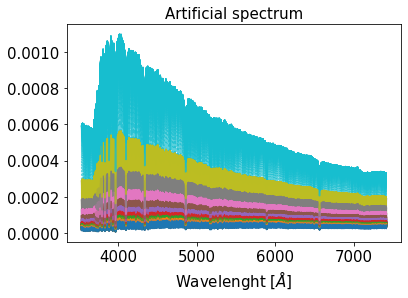

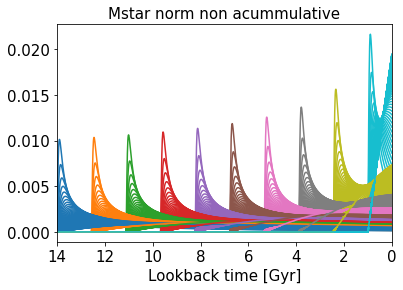

In [36]:
#generate data:
print('Generating data...')
#generate parametrizations (not a lot, just to train)
print('Step 1/4')
#tau from 0.3 to 5 
t,ms,percentiles=generate_weights_from_SFHs(SFR=sfr_linear_lorentz,mgal=10**10,gamma=np.linspace(0.1,5,100),ti=np.linspace(0,13,10),tmin=0,tmax=14,step=0.01,percen=True)
#load MILES spectra and interpolate
print('Step 2/4')
wave,data=get_data(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
tbins=get_tbins(dir_name='../../MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
print('Step 3/4')
data_extended=interpolate(tbins,t,data)
#generate spectra for the parametrized SFHs
print('Step 4/4')
wave,seds=generate_all_spectrums(t,ms,wave,data_extended)
np.save('./saved_input/t_lorentz_long.npy',t)
np.save('./saved_input/percentiles_lorentz_long.npy',percentiles)
np.save('./saved_input/waves_lorentz_long.npy',wave)
np.save('./saved_input/seds_lorentz_long.npy',seds) 
np.save('./saved_input/sfh_lorentz_long.npy',ms)

plot_sed_sfh(ms,t,wave,seds,1)

In [37]:
t=np.array(t)
percentiles=np.array(percentiles)
wave=np.array(wave)
seds=np.array(seds)
ms=np.array(ms)

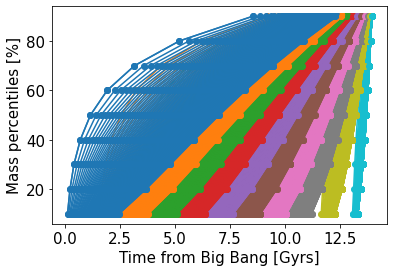

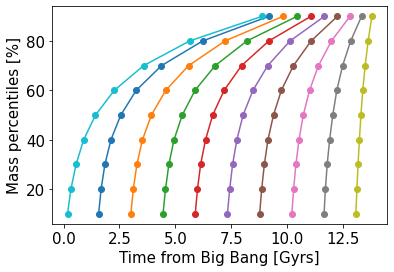

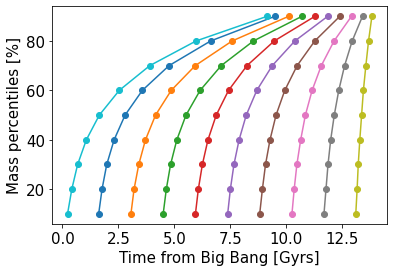

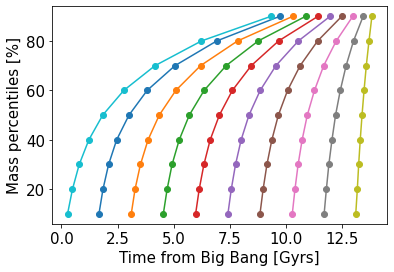

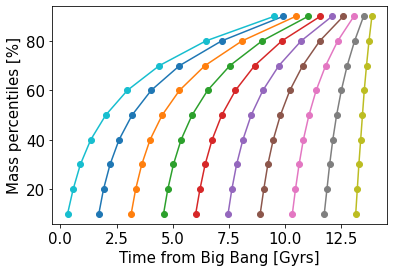

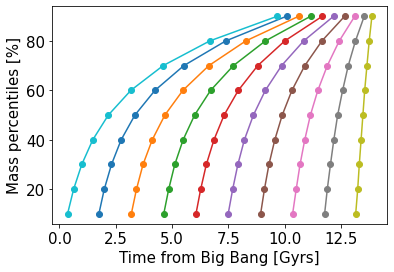

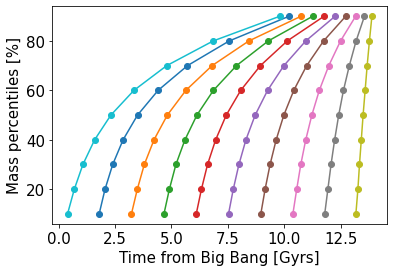

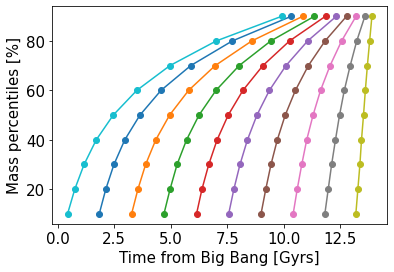

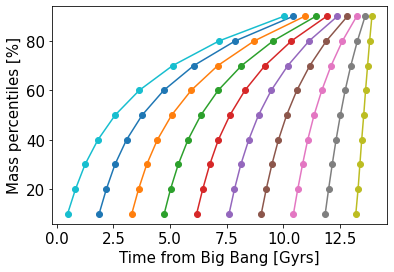

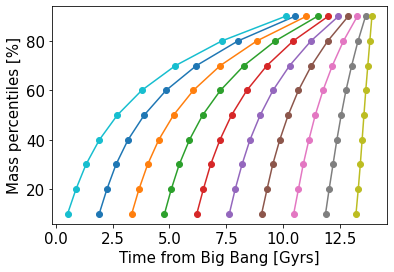

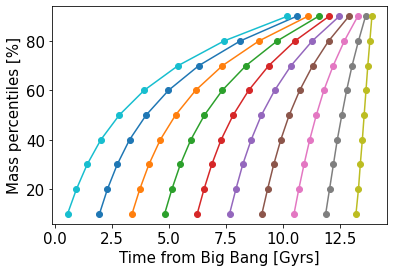

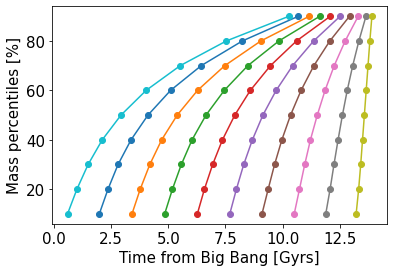

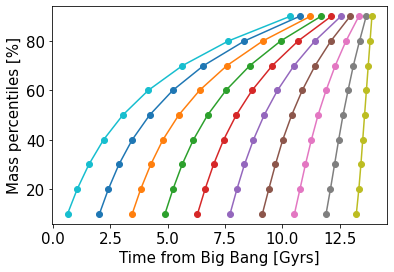

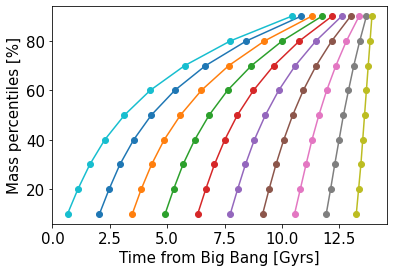

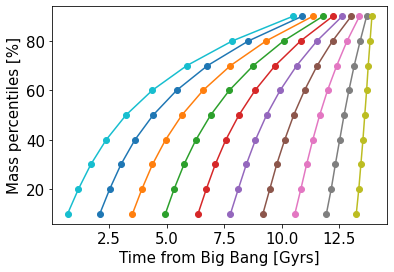

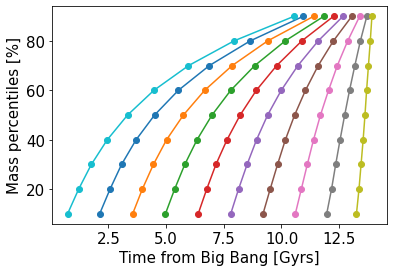

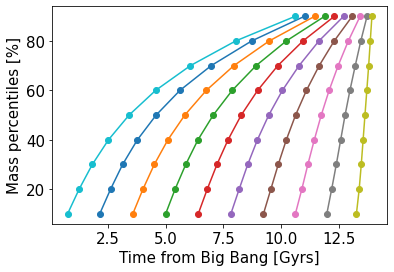

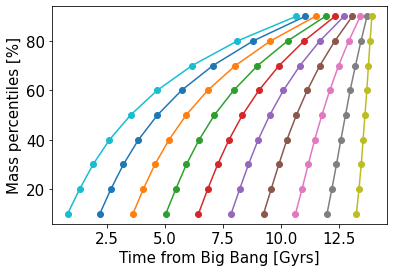

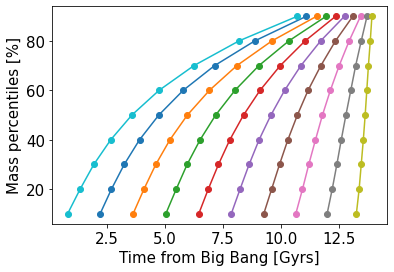

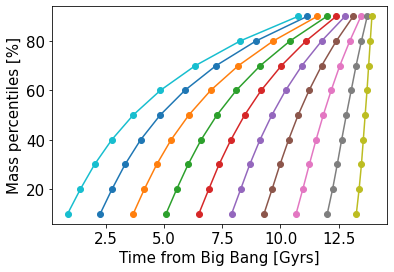

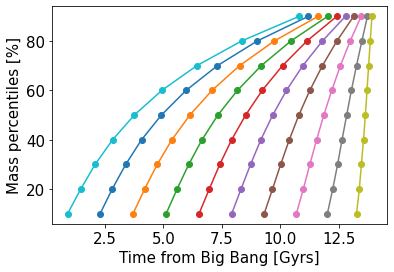

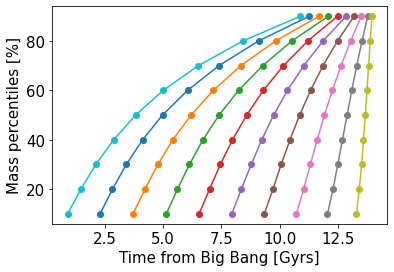

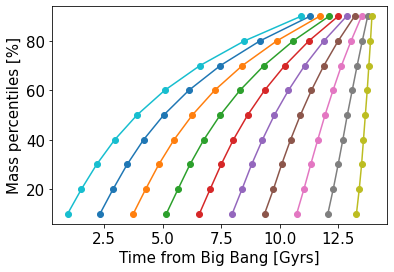

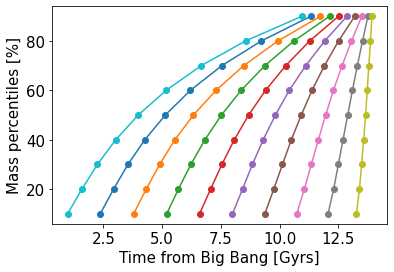

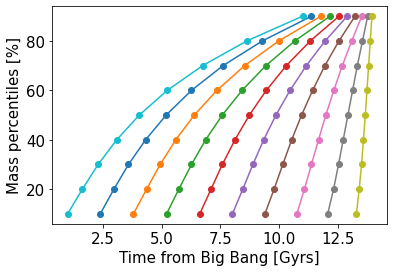

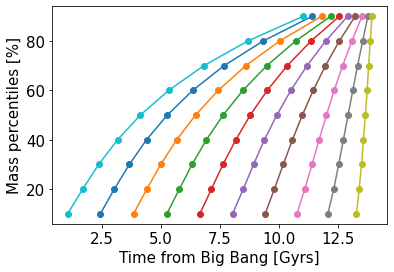

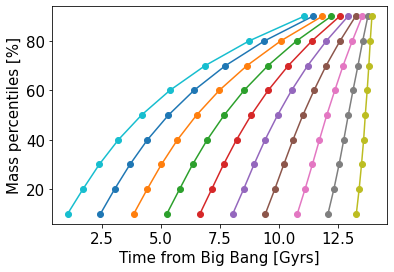

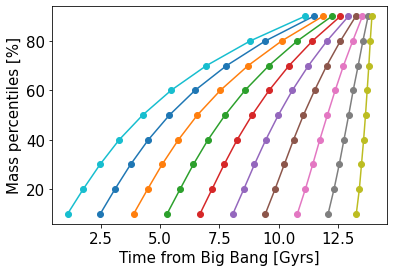

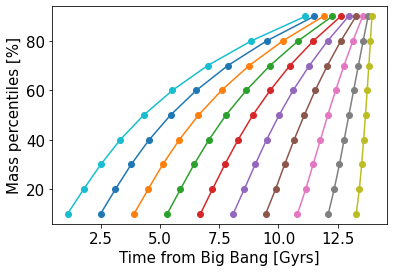

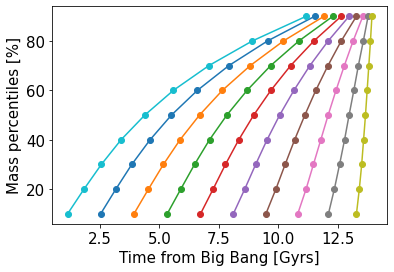

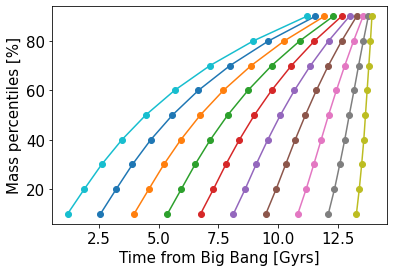

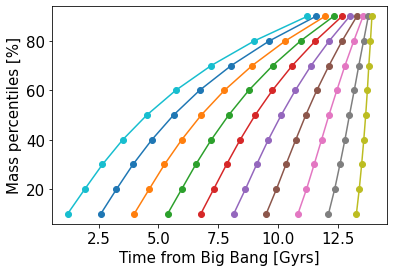

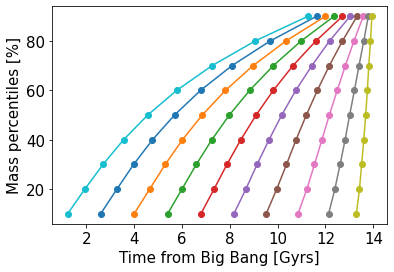

KeyboardInterrupt: 

In [38]:
for i in range(len(percentiles[:,0])):
    plt.plot(percentiles[i,:],np.arange(10,100,10),'-o')
plt.xlabel('Time from Big Bang [Gyrs]')
plt.ylabel('Mass percentiles [%]')
    
for i in range(len(percentiles[:,0])):
    plt.plot(percentiles[i,:],np.arange(10,100,10),'-o')
    if i%10==0:
        plt.xlabel('Time from Big Bang [Gyrs]')
        plt.ylabel('Mass percentiles [%]')
        plt.show()

Now that we have our input (spectra + real percentiles) we load a trained model and use it to predict the percentiles of these spectra

In [39]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        self.y=torch.from_numpy(y) #percentiles


    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        y=self.y[index,:]
        return x,y

#create a pytorch dataset

dataset = Dataset(seds[:,:], percentiles[:,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "../../spender/saved_model/generate_latent_2/latent_"+str(n_latent)+"/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=9)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

Getting latent vectors and predicted percentiles


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.49it/s]


In [40]:
file="../saved_models/best/my_posterior_1e5_m216.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

In [41]:
posteriors=[]


for i in trange(1000):
    posteriors.append(np.array(qphi.sample((1,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)[:,0,:]

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 64.53it/s]


(1000, 9)


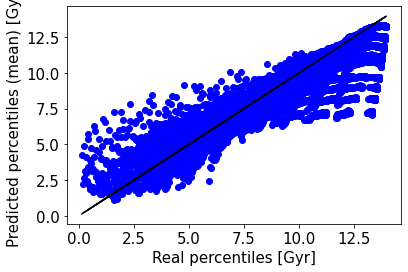

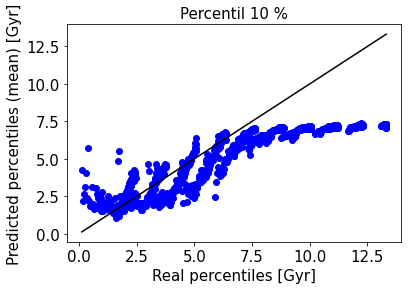

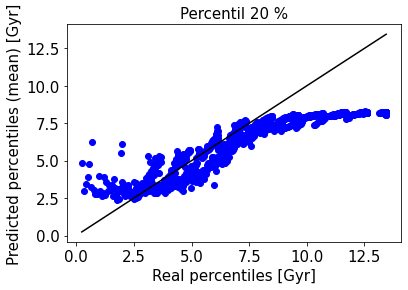

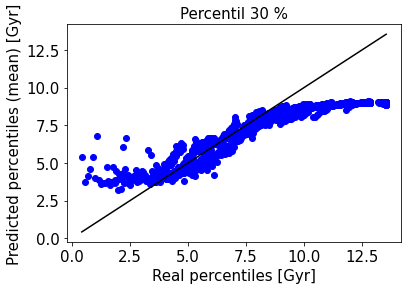

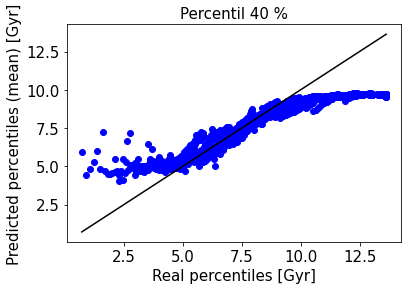

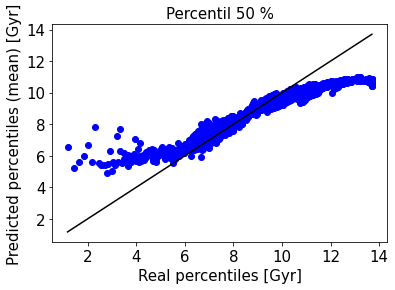

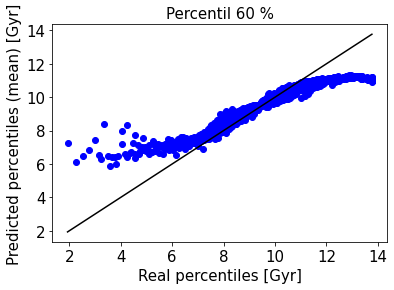

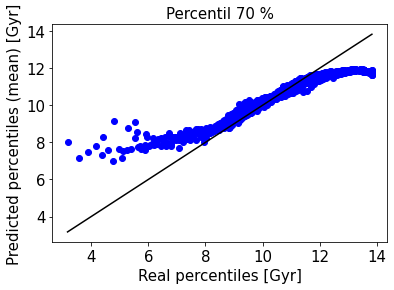

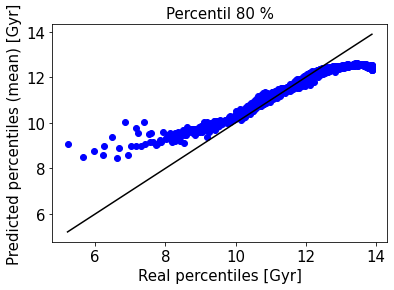

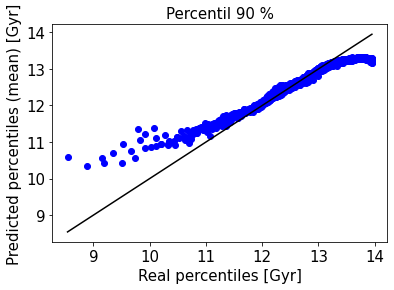

In [46]:
print(np.shape(posteriors))

for i in range(9):
    plt.plot(percentiles[:,i],posteriors[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
plt.xlabel('Real percentiles [Gyr]')
plt.ylabel('Predicted percentiles (mean) [Gyr]')
plt.show()

for i in range(9):
    plt.plot(percentiles[:,i],posteriors[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
    plt.title('Percentil '+str((i+1)*10)+' %')
    plt.xlabel('Real percentiles [Gyr]')
    plt.ylabel('Predicted percentiles (mean) [Gyr]')
    plt.show()

Right now we try to predict distributions (1000 samples)

In [47]:
posteriors_dist=[]


for i in trange(1000):
    posteriors_dist.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors_dist=np.array(posteriors_dist)

100%|███████████████████████████████████████| 1000/1000 [04:37<00:00,  3.61it/s]


(1000, 1000, 9)
(1000, 9)


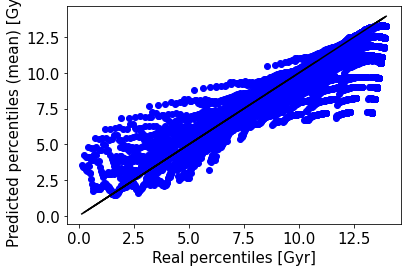

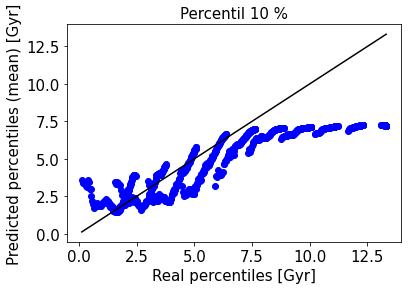

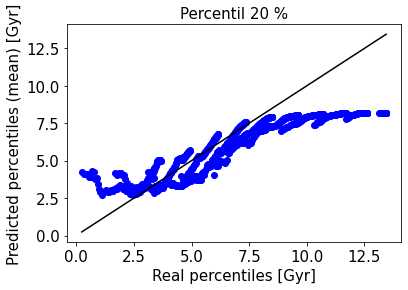

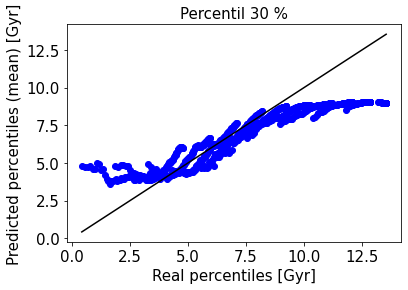

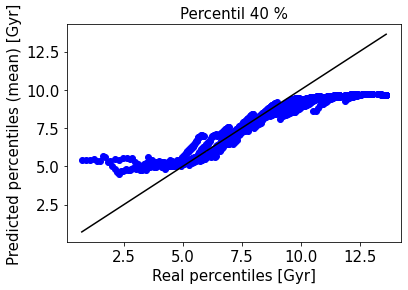

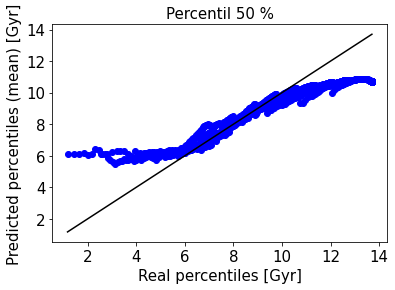

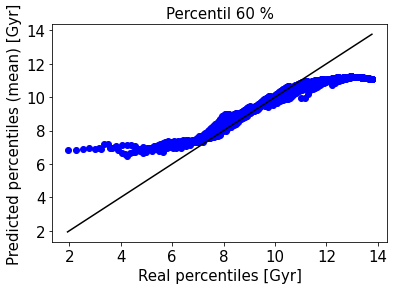

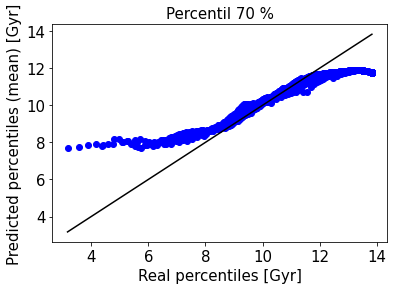

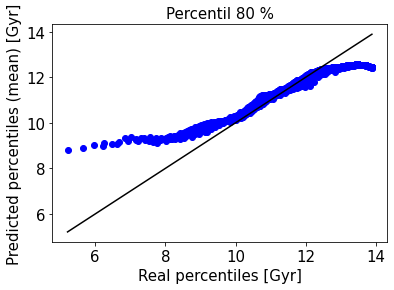

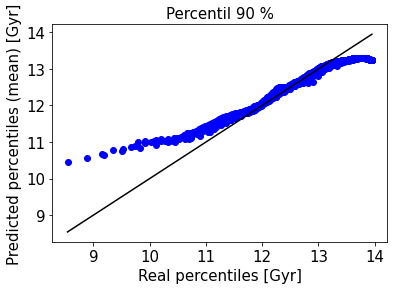

In [48]:
print(np.shape(posteriors_dist))

means=np.mean(posteriors_dist,axis=1)
stds=np.std(posteriors_dist,axis=1)

print(np.shape(means))


for i in range(9):
    plt.plot(percentiles[:,i],means[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
plt.xlabel('Real percentiles [Gyr]')
plt.ylabel('Predicted percentiles (mean) [Gyr]')
plt.show()


for i in range(9):
    plt.plot(percentiles[:,i],means[:,i],'bo')
    plt.plot(percentiles[:,i],percentiles[:,i],'k-')
    plt.title('Percentil '+str((i+1)*10)+' %')
    plt.xlabel('Real percentiles [Gyr]')
    plt.ylabel('Predicted percentiles (mean) [Gyr]')
    plt.show()

Let's see if the error is well estimated

In [49]:
import math

def get_coverage_probabilities_nomodel(y_real,y_pred,y_pred_std):
    """
    Compute the coverage probabilities on test dataset
    
    :param y:  The data true values
    :param y_pred: The mean of the predicted distributions
    :param y_pred_std: The standard deviation of the predicted distributions
    :return: (x, y) a tuple of lists corresponding to a list of probability volumes
    and the corresponding percentage of true values in that volume.
    """
    

    errors = np.absolute(y_real - y_pred)
    x, y = [], []
    for sigma_times in np.arange(0, 3, 0.01):
        how_many = np.count_nonzero(errors <= sigma_times * y_pred_std)
        y.append(how_many / y_real.shape[0])
        x.append(math.erf(sigma_times / math.sqrt(2))) #the method erf returns the error function of a number.
    return x, y


def plot_with_median(data_x, data_y,ax, label=None, percentiles=(16, 84), total_bins=20):
    """
    Plot the running media of the data_x, data_y data with requested percentiles.
    :param data_x:
    :param data_y:
    :param label: The label that should be displayed on the legend
    :param percentiles: The percentiles to plot along with the median
    :param total_bins: The number of bins to digitize the data. Increase to increase detail.
    :return:
    """
    bins = np.linspace(data_x.min(), data_x.max(), total_bins)

    delta = bins[1] - bins[0]
    idx = np.digitize(data_x, bins)
    running_median = [np.nanmedian(data_y[idx == k]) for k in range(total_bins)]
    running_prc_low = [np.nanpercentile(data_y[idx == k], percentiles[0])
                       for k in range(total_bins)]
    running_prc_high = [np.nanpercentile(data_y[idx == k], percentiles[1])
                        for k in range(total_bins)]

    if percentiles:
        ax.plot(bins-delta/2, running_median, lw=2, alpha=.8, color='blue', label=label)
        ax.fill_between(bins - delta / 2, running_prc_low, running_median, color='blue', alpha=0.1)
        ax.fill_between(bins - delta / 2, running_prc_high, running_median, color='blue', alpha=0.1)
    else:
        ax.plot(bins - delta / 2, running_median, linestyle='--', lw=2, alpha=.8,  label=label)
        
        
def init_coverage_plot():
    """
    Initialize the coverage plot and add text for marking
    overconfident and conservative regions
    :return:
    """
    f = plt.figure(figsize=(10, 8))
    ax = f.add_subplot()
    ax.set_xlabel('Percentage of probability volume')
    ax.set_ylabel('Percentage of true values in volume')
    ax.set_title('Probability Coverage')

    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.text(0.3, 0.9, '$\it{Conservative}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)

    plt.text(0.7, 0.1, '$\it{Overconfident}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
    return f, ax

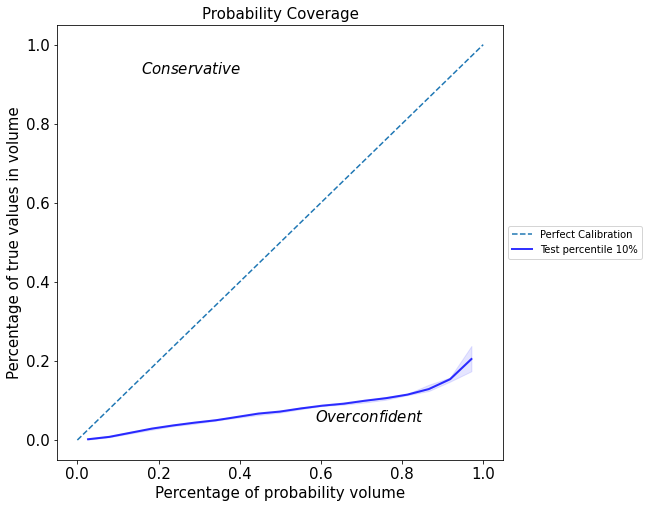

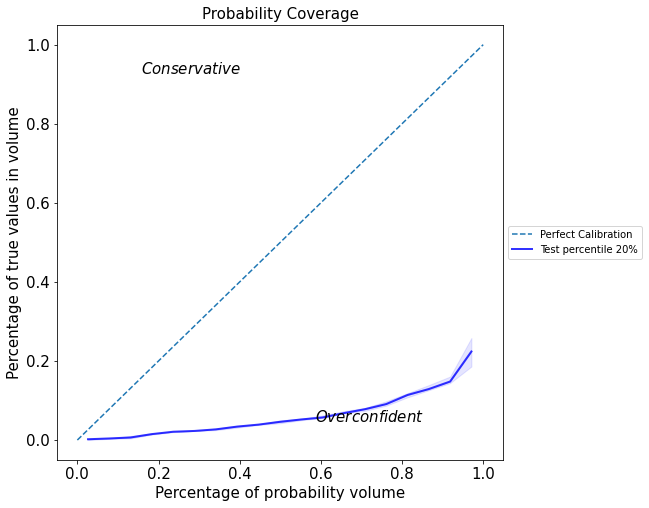

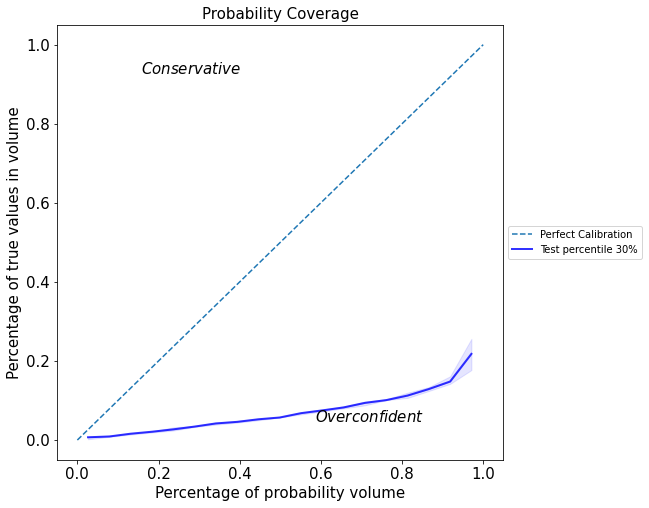

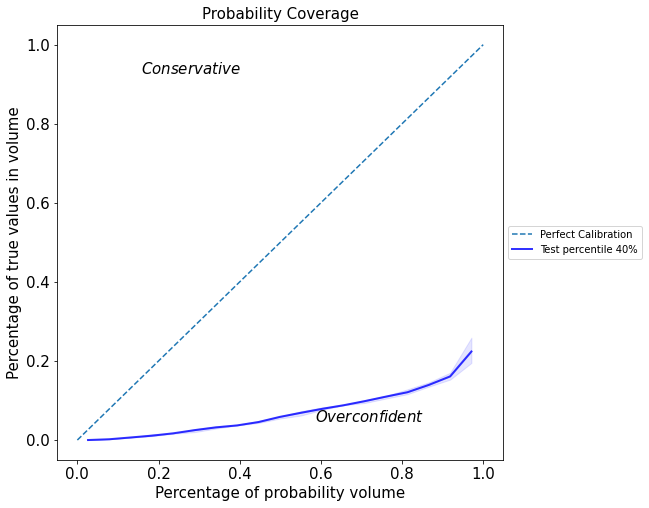

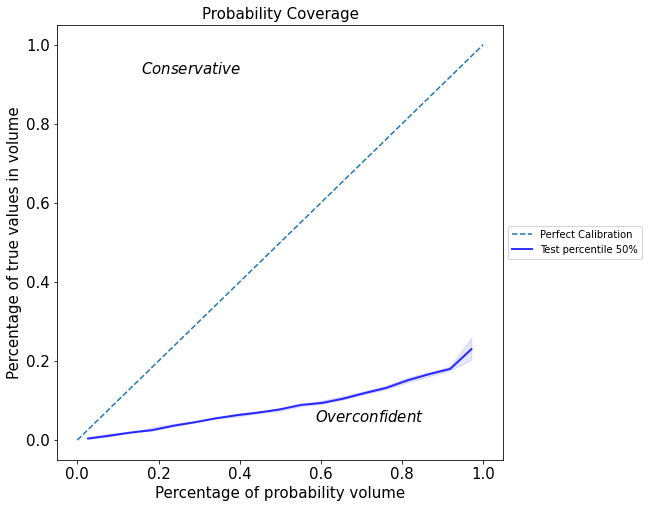

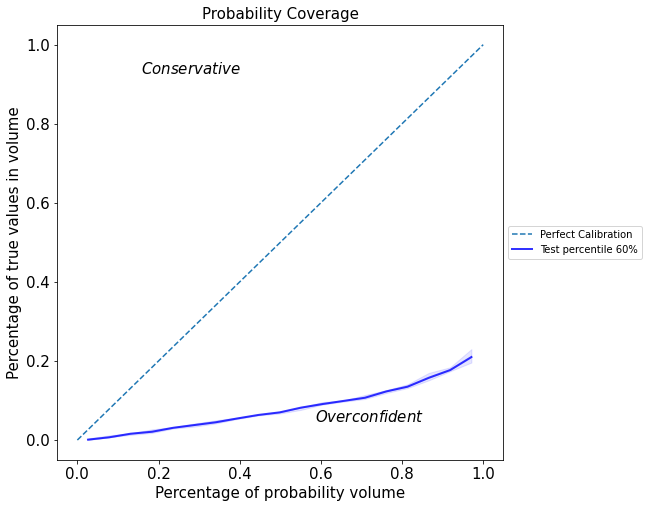

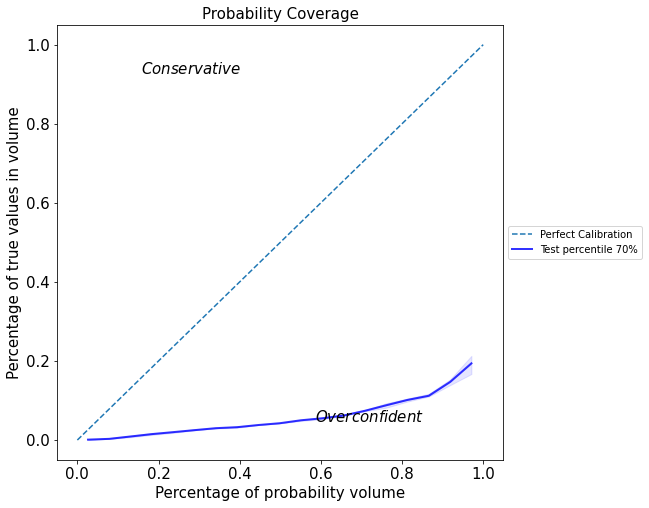

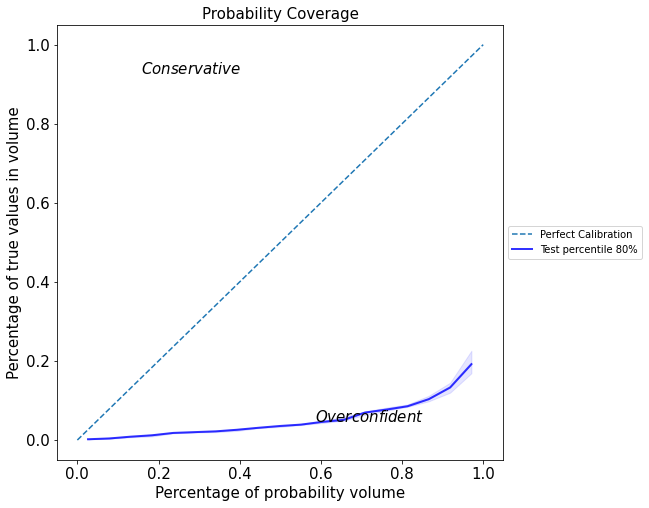

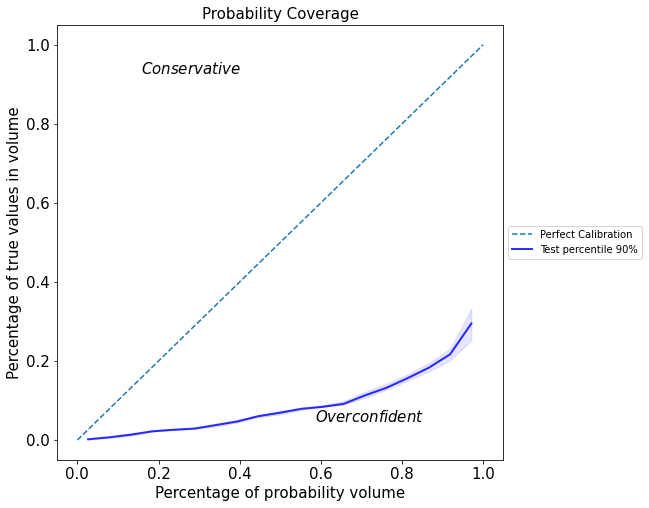

In [50]:
y=np.copy(percentiles)
y_pred=np.copy(means)
y_pred_std=np.copy(stds)


for i in range(9):
    
    data_x,data_y=get_coverage_probabilities_nomodel(np.array(y)[:,i],y_pred[:,i],y_pred_std[:,i])
    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', titlesize=15, labelsize=15)
    f, ax =init_coverage_plot()
    
    if i<9:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Test percentile '+str((i+1)*10)+'%')
    else:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Metallicity')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    #plt.savefig('coverage_'+str(i)+'.jpg')
    plt.show()
    plt.close()



Finally, we do a corner plot to check the predicted posterior distributions

0it [00:00, ?it/s]

index:  718


1it [00:04,  4.47s/it]

index:  23


2it [00:05,  2.45s/it]

index:  457


3it [00:06,  1.73s/it]

index:  592


4it [00:08,  1.81s/it]

index:  78


5it [00:09,  1.84s/it]


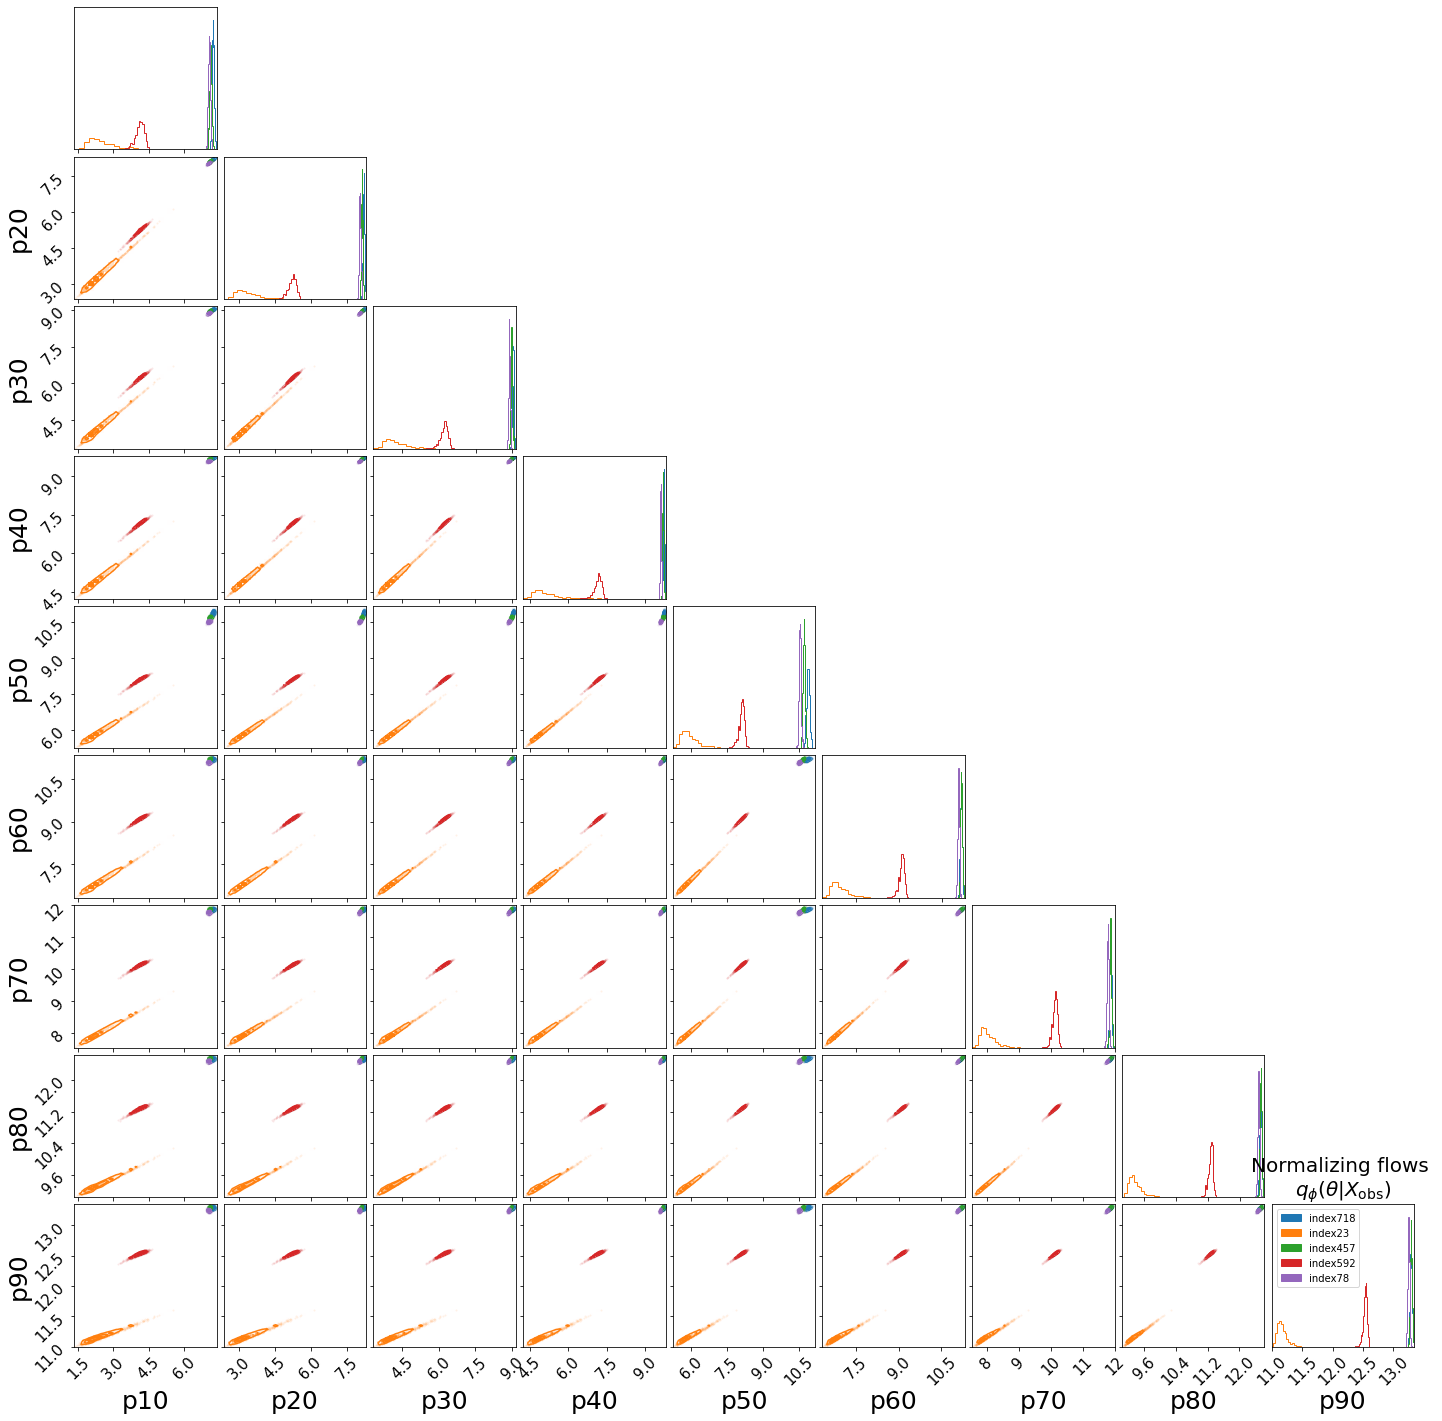

In [51]:
import corner

best_list=np.random.randint(0,1000,5)

fig=plt.figure(figsize=(20,20))

posteriors=[]

for k,j in tqdm(enumerate(best_list)):
    print('index: ',j)
    Xobs=ss[j,:]
    posterior_samples = np.array(qphi.sample((1000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))
    posteriors.append(posterior_samples)
    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10) for i in range(1,10)] #label for percentiles

    #we plot all the percentiles
    _ = corner.corner(posterior_samples[:,:], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(j))
    
plt.legend(loc='upper left', fontsize=10)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$',fontsize=20)
plt.show()